In [1]:
#@Author XIAZIHANG
import xgboost as xgb
from xgboost import XGBRegressor
from xgboost import plot_importance
import numpy  as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.model_selection import cross_val_score as CVS, KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error as MSE
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier 
from sklearn.preprocessing import LabelEncoder

from matplotlib import pyplot
from xgboost import plot_importance
from datetime import datetime

from sklearn.metrics import accuracy_score

#from sklearn.model_selection import RepeatedStratifiedKFold

import warnings
warnings.filterwarnings("ignore")

from time import time
import datetime

# df= pd.read_csv('file.csv')


file_name = '__wind__.csv' 

df = pd.read_csv(file_name)
# dfdata = df.loc[:,['T','direction32','ws30','dir10','mslp','clc','senf','latf','swr','lwr','ps','T2m','RH2m','Time','month']]


In [2]:

train_set= 600 # 需要600天作为学习
train_perday= 96 # 每天有96个点
data_train = train_set*train_perday  # 共计有这么多点 

period = 1 # 一天一段这个可以看为一个 test_perday 的倍数
test_set = 3 # 分三段
test_perday= 96 # 每段有96个点


predict_dic = locals()

df_train = df.iloc[:data_train]# XGB的训练集

def DATA_Split(train_set,train_perday,test_perday,test_set,period,df):
    data_train = train_set*train_perday  # 共计有这么多点 

    for i in range(1,test_set+1):# 从1 开始是为了 不从0开始
        former  = data_train + (i-1)*test_perday # 用于分界的数据的前边界
        latter = data_train  + (i-1+period)*test_perday #用于学习数据的后边界  
        predict_dic['predict' + str(i) ]  = df.iloc[former : latter] # 切分
        # print('边界',former,latter)
    
    return predict_dic

predict_dic = DATA_Split(train_set,train_perday,test_perday,test_set,period,df)
dfdata = df.loc[:,df.columns.drop('power')]





In [3]:
def R2_func(y_train,y_pred):
    R22  = r2_score(y_train,y_pred)
    return R22

def rmse_func(y_prediction,y_real):
    return np.sqrt(MSE(y_prediction,y_real))

def smape_func(A,F):
    return 1/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

def get_xy(df_train,y_colunm = 'power'):
    y_train = df_train[y_colunm]
    X_train = df_train.loc[:,df_train.columns.drop(y_colunm)]
    return X_train, y_train


In [4]:
### fit model for train data
model = XGBRegressor()

 

[01:34:39] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:627: 
Parameters: { "min_child_samples" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

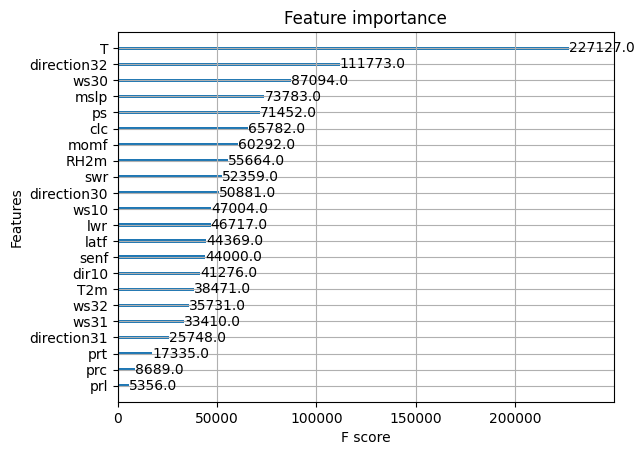

In [5]:

best_part = {'subsample': 1,
'objective' :'reg:linear',
 'reg_lambda': 1,
 'reg_alpha': 0.005,
 'n_estimators': 300,
 'min_child_samples': 10,
 'max_depth':15,
 'learning_rate': 0.005,
 'gamma': 0,
 'colsample_bytree': 0.8
 }

model = XGBRegressor(max_depth=best_part['max_depth'],
                    n_estimators= best_part['n_estimators'],
                    learning_rate = best_part['learning_rate'],
                    min_child_samples = best_part['min_child_samples'],
                    colsample_bytree = best_part['colsample_bytree'],
                    gamma = best_part['gamma'],
                    booster='gbtree',
                    reg_alpha=best_part['reg_alpha'],
                    reg_lambda=best_part['reg_lambda'],

)
X_train, y_train = get_xy(df_train=df_train)
model.fit(X_train,y_train)
 
plot_importance(model)

In [6]:
y_pred = model.predict(X_train)
R22 =  R2_func(y_train,y_pred)
print('训练集的R2',R22)

def  Assessment_criteria(y_test,y_pred_test,silent=0,str1 = ''):
    # 评估标准 大于 0.1才算有效
    
    valid = pd.DataFrame()
    valid['power'] =y_test 
    valid['prediction'] = y_pred_test

    valid_larger = valid[valid['power'] >=0.1]
    y_prediction = valid_larger['prediction']
    y_real = valid_larger['power']

    R2  = R2_func(y_test,y_pred_test)
    MAPE1 = MAPE(y_prediction,y_real)
    smape = smape_func(y_prediction,y_real)
    RMSE = rmse_func(y_prediction,y_real)
    if silent != 1:
        print(str1,'R2       ',R2) 
        print(str1,'MAPE     ',MAPE1)
        print(str1,'RSME     ',RMSE)
        print(str1,'预测平均值 ',y_prediction.mean())
        print(str1,'真实平均值 ',y_real.mean())
        print(str1,'SMAPE',smape)
        print()
    
    return 

Assessment_criteria(y_train,y_pred,str1 = '训练集')



silent = 0 
R2_dic = locals()
MAPE_dic = locals()
SMAPE_dic = locals()
RMSE_dic = locals()



for i in range(1,test_set+1):# 从1 开始是为了 不从0开始
    X_test,y_test = get_xy(predict_dic.get('predict'+str(i)))
    y_pred_test = model.predict(X_test)

    valid = pd.DataFrame()
    valid['power'] =y_test 
    valid['prediction'] = y_pred_test

    valid_larger = valid[valid['power'] >=0.1]
    y_prediction = valid_larger['prediction']
    y_real = valid_larger['power']

    R2_dic   ['R2'   + str(i)] = R2_func   (y_test,y_pred_test)
    MAPE_dic ['MAPE' + str(i)] = MAPE      (y_prediction,y_real)
    SMAPE_dic['SMAPE'+ str(i)] = smape_func(y_prediction,y_real)
    RMSE_dic ['RMSE' + str(i)] = rmse_func (y_prediction,y_real)
    if silent != 1:
        print('第',i,'周期 R2       ',R2_dic.get('R2'+str(i))) 
        print('第',i,'周期 MAPE     ',MAPE_dic.get('R2'+str(i)))
        print('第',i,'周期 RSME     ',RMSE_dic.get('RMSE'+str(i)))
        print('第',i,'周期 预测平均值 ',y_prediction.mean())
        print('第',i,'周期 真实平均值 ',y_real.mean())
        print('SMAPE',SMAPE_dic.get('SMAPE'+str(i)))
        print()
    
     

训练集的R2 0.8073163519487723
训练集 R2        0.8073163519487723
训练集 MAPE      0.44997169191772673
训练集 RSME      10.500124816289349
训练集 预测平均值  18.382296
训练集 真实平均值  24.034214593169654
训练集 SMAPE 0.5354428920458493

第 1 周期 R2        -0.45433238262503606
第 1 周期 MAPE      -0.45433238262503606
第 1 周期 RSME      17.666417161749866
第 1 周期 预测平均值  24.519201
第 1 周期 真实平均值  17.849434312499998
SMAPE 0.750218236051607

第 2 周期 R2        -0.6140902241743009
第 2 周期 MAPE      -0.6140902241743009
第 2 周期 RSME      16.57614999769955
第 2 周期 预测平均值  22.601425
第 2 周期 真实平均值  12.34830859375
SMAPE 0.9813934587568653

第 3 周期 R2        -1.6705337879244797
第 3 周期 MAPE      -1.6705337879244797
第 3 周期 RSME      27.575014771349977
第 3 周期 预测平均值  30.900053
第 3 周期 真实平均值  50.595972395833336
SMAPE 0.5449875823667053



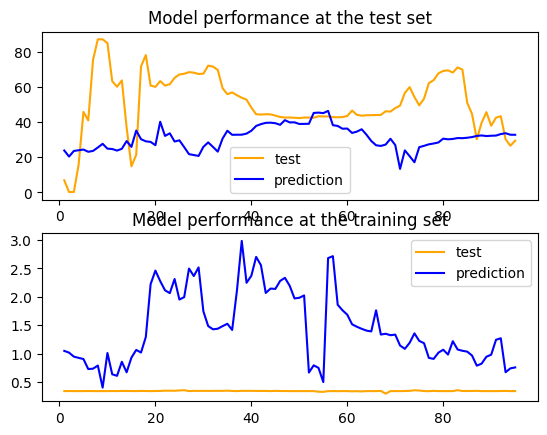

In [7]:
from numpy import size


plt.subplot(2, 1, 1)
plt.plot(range(1,96),y_test[:95],c="orange",label="test")
plt.plot(range(1,96),y_pred_test[:95],c="blue",label="prediction")
plt.title('Model performance at the test set')

plt.legend()

plt.subplot(2, 1, 2)
plt.plot(range(1,96),y_train[:95],c="orange",label="test")
plt.plot(range(1,96),y_pred[:95],c="blue",label="prediction")
plt.title('Model performance at the training set')
plt.legend()

In [8]:
# 这个是之前提到的那个百分率
# accuracy_factor = np.sqrt(sum((np.array(y_prediction) - np.array(y_real)) ** 2  / (y_real**2) ) )/len(y_real)

# print(accuracy_factor)
